# HW 3
## Model-based Bias Removal in Machine Learning using Synthetic Blood Pressure Data
Objective: Explore bias from imbalanced datasets and evaluate mitigation methods; generate synthetic data for /n
males and females with provided statistics for systolic blood pressure (SBP) and diastolic blood pressure (DBP) /n
using a bivariate normal model; train a binary classifier to predict sex based on SBP and DBP, varying male/female /n
ratios; evaluate model performance (ROC, F1 score, accuracy) and discuss biases arising from imbalances; reflect on /n
the importance of balanced data, challenges in real datasets, and propose bias mitigation strategies.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [ ]:
# Propose Mathematical Models for SBP and DBP: 

a = int
age = a

# Sigmoidal
def sig_SBP(a, Smax, k, a0):
    return Smax / (1 + np.exp(-k * (a - a0)))

# Gaussian
def gauss_DBP(a, Dmax, a_peak, width):
    return Dmax * np.exp(-((a - a_peak)**2) / (2 * width**2))

# Polynomial Regression Model
def poly_SBP(a, c1, c2, c3):
    return c1 * (a**2) + c2 * (a) + c3

def poly_DBP(a, d1, d2, d3):
    return d1 * (a**2) + d2 * (a) + d3

In [ ]:
# Added in table data from paper and read into pandas df, took out commas
BP_across_age = pd.read_csv('BP.txt', sep=r'\s+', thousands=',')

# Need to make the ranges into actual numbers for model
age_middle = {
    '<20': 15,
    '20-29': 25,
    '30-39': 35,
    '40-49': 45,
    '50-59': 55,
    '60-69': 65,
    '70-79': 75,
    '80-89': 85,
    '≥90': 95
}

# Added new column and then converted from strings to floats
BP_across_age['age_avg'] = BP_across_age['Age'].map(age_middle)
columns_to_convert = ['meanSBP', 'stdSBP', 'meanDBP', 'stdDBP', 'ρ(SBP,DBP)', 'age_avg']
BP_across_age[columns_to_convert] = BP_across_age[columns_to_convert].astype(float)

ages = BP_across_age['age_avg'].values
sbps = BP_across_age['meanSBP'].values
dbps = BP_across_age['meanDBP'].values

# Fit Polynomial model and determine parameters
polyfit_SBP, _ = curve_fit(poly_SBP, ages, sbps)
polyfit_DBP, _ = curve_fit(poly_DBP, ages, dbps)
c1, c2, c3 = polyfit_SBP
print(f"Polynomial SBP Parameters:\n"
      f"c1: {c1}\n"
      f"c2: {c2}\n"
      f"c3: {c3}\n")
d1, d2, d3 = polyfit_DBP
print(f"Polynomial DBP Parameters:\n"
      f"d1: {d1}\n"
      f"d2: {d2}\n"
      f"d3: {d3}\n")

# Fit Sigmoidal-Gaussian and determine parameters
sigfit_SBP, _ = curve_fit(sig_SBP, ages, sbps, p0=(160, 0.1, 55))
gaussfit_DBP, _ = curve_fit(gauss_DBP, ages, dbps, p0=(80, 50, 20))
Smax, k, a0 = sigfit_SBP
print(f"Sigmoidal SBP Parameters:\n"
      f"Smax: {Smax}\n"
      f"k: {k}\n"
      f"a0: {a0}\n")
Dmax, a_peak, width = gaussfit_DBP
print(f"Gaussian DBP Parameters:\n"
      f"Dmax: {Dmax}\n"
      f"a_peak: {a_peak}\n"
      f"width: {width}\n")

# Create prediction data dataframe
pred_poly_SBP = poly_SBP(ages, *polyfit_SBP)
pred_poly_DBP = poly_DBP(ages, *polyfit_DBP)
pred_sig_SBP = sig_SBP(ages, *sigfit_SBP)
pred_gauss_DBP = gauss_DBP(ages, *gaussfit_DBP)

predictions_df = pd.DataFrame({
    'Age_Middle': ages,
    'Actual_SBP': sbps,
    'Predicted_Poly_SBP': pred_poly_SBP,
    'Predicted_Sig_SBP': pred_sig_SBP,
    'Actual_DBP': dbps,
    'Predicted_Poly_DBP': pred_poly_DBP,
    'Predicted_Gauss_DBP': pred_gauss_DBP
})

print(predictions_df)

Polynomial SBP Parameters:
c1: -0.0020222943722938425
c2: 0.4988857142856753
c3: 108.85470021645126

Polynomial DBP Parameters:
d1: -0.005561255411254962
d2: 0.5833380952380576
d3: 63.111150432901496

Sigmoidal SBP Parameters:
Smax: 145.25974335449789
k: 0.019839335660418216
a0: -53.8108700301842

Gaussian DBP Parameters:
Dmax: 78.50436221654194
a_peak: 52.27779418080324
width: 81.14056751771523

   Age_Middle  Actual_SBP  Predicted_Poly_SBP  Predicted_Sig_SBP  Actual_DBP  \
0        15.0      115.05          115.882970         115.713529       69.80   
1        25.0      121.27          120.062909         120.109896       74.27   
2        35.0      123.79          123.838390         123.972443       77.31   
3        45.0      127.32          127.209411         127.330328       79.36   
4        55.0      129.98          130.175974         130.222781       79.05   
5        65.0      132.42          132.738078         132.694658       76.71   
6        75.0      134.62          134.8

Polynomial SBP:
MSE: 0.2724257046657037
R-squared: 0.9948223391877238
Sigmoidal SBP:
MSE: 0.2326412351863876
R-squared: 0.9955784737412272
Polynomial DBP:
MSE: 1.030263559403556
R-squared: 0.9152190834424905
Gaussian DBP:
MSE: 0.9383982634376831
R-squared: 0.9227787257502534


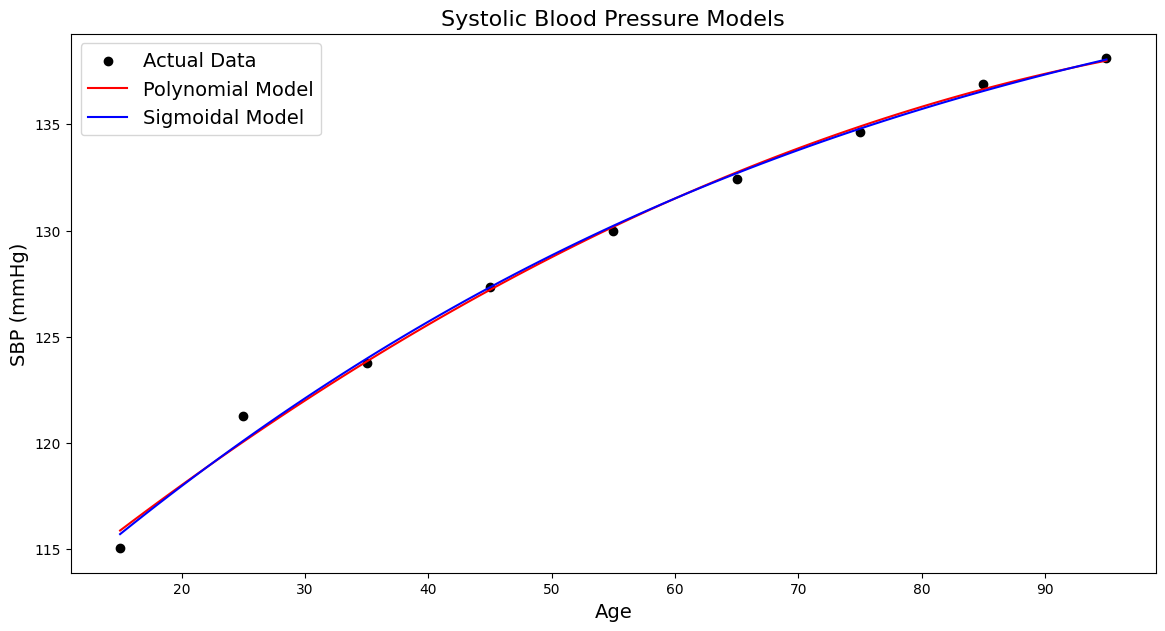

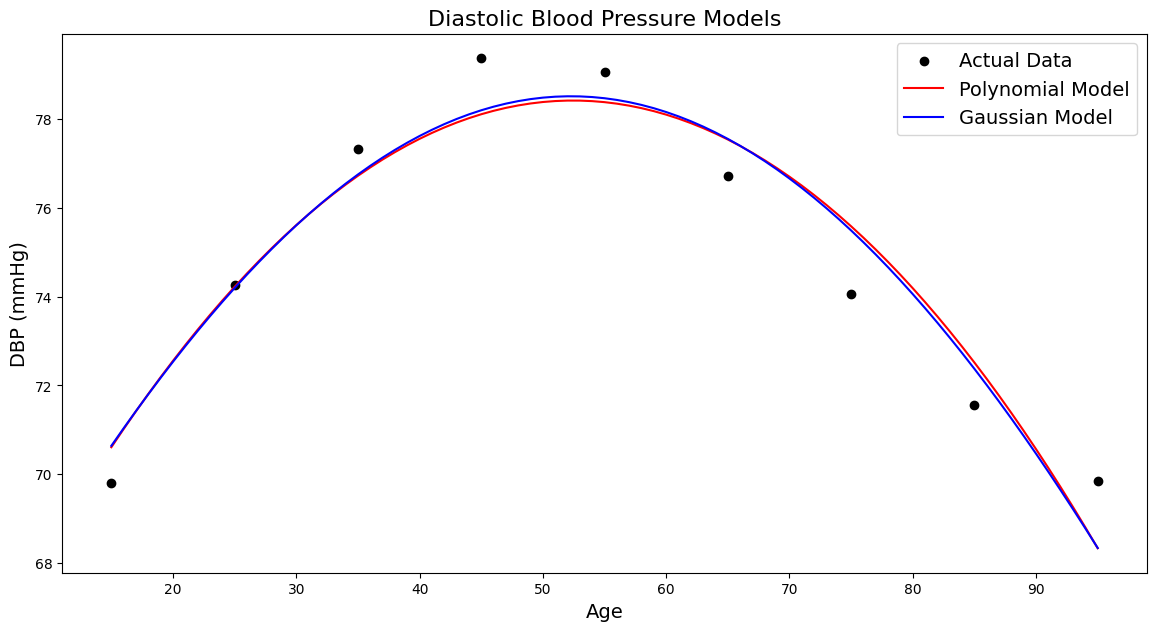

In [ ]:
# Quantitative Evaluation of Model Fit: 
# Compute the Mean Squared Error (MSE) for each model,
# and calculate R-squared (R2) values to assess model fit.
# Plot model curves for SBP and DBP against the
# plots in the preprint.

# y_true = actual values
# y_pred = predicted values

# Calculate MSE
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Calculate R-squared
def r_squared(y_true, y_pred):
    y_mean = np.mean(y_true)
    ss_tot = np.sum((y_true - y_mean) ** 2) # Total sum of squares
    ss_res = np.sum((y_true - y_pred) ** 2) # Residual sum of squares
    r_squared_val = 1 - (ss_res / ss_tot)
    return r_squared_val

# Polynomial SBP
mse_poly_SBP = mse(sbps, pred_poly_SBP)
r_squared_poly_SBP = r_squared(sbps, pred_poly_SBP)
print(f"Polynomial SBP:\nMSE: {mse_poly_SBP}\nR-squared: {r_squared_poly_SBP}")

# Sigmoidal SBP
mse_sig_SBP = mse(sbps, pred_sig_SBP)
r_squared_sig_SBP = r_squared(sbps, pred_sig_SBP)
print(f"Sigmoidal SBP:\nMSE: {mse_sig_SBP}\nR-squared: {r_squared_sig_SBP}")

# Polynomial DBP
mse_poly_DBP = mse(dbps, pred_poly_DBP)
r_squared_poly_DBP = r_squared(dbps, pred_poly_DBP)
print(f"Polynomial DBP:\nMSE: {mse_poly_DBP}\nR-squared: {r_squared_poly_DBP}")

# Gaussian DBP
mse_gauss_DBP = mse(dbps, pred_gauss_DBP)
r_squared_gauss_DBP = r_squared(dbps, pred_gauss_DBP)
print(f"Gaussian DBP:\nMSE: {mse_gauss_DBP}\nR-squared: {r_squared_gauss_DBP}")

# Plot SBP model curves against preprint data
age_range = np.arange(15, 96)
pred_poly_sbp_curve = poly_SBP(age_range, *polyfit_SBP)
pred_sig_sbp_curve = sig_SBP(age_range, *sigfit_SBP)
fig, ax = plt.subplots(figsize=(14,7))
ax.set_title('Systolic Blood Pressure Models', fontsize=16)
ax.set_xlabel('Age', fontsize=14)
ax.set_ylabel('SBP (mmHg)', fontsize=14)
ax.scatter(ages, sbps, label='Actual Data', color='black')
ax.plot(age_range, pred_poly_sbp_curve, label='Polynomial Model', color='red')
ax.plot(age_range, pred_sig_sbp_curve, label='Sigmoidal Model', color='blue')
ax.legend(fontsize=14)
plt.show()

# Plot DBP model curves against preprint data
pred_poly_dbp_curve = poly_DBP(age_range, *polyfit_DBP)
pred_gauss_dbp_curve = gauss_DBP(age_range, *gaussfit_DBP)
fig, ax = plt.subplots(figsize=(14,7))
ax.set_title('Diastolic Blood Pressure Models', fontsize=16)
ax.set_xlabel('Age', fontsize=14)
ax.set_ylabel('DBP (mmHg)', fontsize=14)
ax.scatter(ages, dbps, label='Actual Data', color='black')
ax.plot(age_range, pred_poly_dbp_curve, label='Polynomial Model', color='red')
ax.plot(age_range, pred_gauss_dbp_curve, label='Gaussian Model', color='blue')
ax.legend(fontsize=14)
plt.show()

## Interpreting Model Parameters
### Polynomial SBP Parameter (curvature term): c1: -0.0020222943722938425

### Polynomial DBP Parameters (curvature term): d1: -0.005561255411254962

##### The fact that both c1 and d1 are negative, means that the parabola opens downward. In order to determine units of the parameter, I tried to figure it out from the output which is in mmHg. 
If the equation is x1 * (a**2) + (x2 * a) + x3, 

mmmHg = x1 * (years**2) + (x2 * years) + x3

x1 = mmHg / (years**2)

x2 = mmHg / years

x3 = mmHg

### Sigmoidal SBP Parameters:
### Smax: 145.25974335449789
##### This means that the max SBP with age is 145 mmHg (which is likely not true, as blood pressures can go up higher)
### k: 0.019839335660418216
### a0: -53.8108700301842
##### The a0 does not make sense, because it is saying that the age at which SBP reaches half-maximum is -53, which is not biologically possible. This is because we are only seeing the top half of the S-curve. This means that this may not be the best physiological model.

### Gaussian DBP Parameters:
### Dmax: 78.50436221654194

##### This refers to the maximum DBP around middle age, which is 78 mmHg.
### a_peak: 52.27779418080324

##### Age at peak DBP is predicted to be 52, which may be correct as afterwards it begins to fall. 
### width: 81.14056751771523

##### The standard deviation of the Gaussian curve is 81, meaning the spread of the data is 81 years, which makes sense in the setting of normal lifespan.

## Discussion and Analysis: Answer the following
### i. Which model captures age trends in SBP and DBP better?

Based on the MSE and R-squared of the different models, for SBP the Sigmoidal model was the best fit while for DBP the Gaussian model was the best fit. They both had the lowest MSE (error or difference between the model's predictions and the actual data) and the highest R-squared (which tells you how much variation in BP can be explained by the model). The difference between MSE and R-squared was highest for DBP (the Gaussian model was much better than the polynomial). BUT, when determining whether the model is physiologically plausible, the polynomial model for SBP makes more physiological sense. Although the Sigmoidal model has a small statistical edge (in terms of MSE and R2), the polynomial model makes more sense.

### ii. How do model parameters reflect physiological blood pressure changes with age?

The models clearly show that as we age, SBP steadily rises as our vessels become more stiff, and DBP initially increases steadily until a certain point around middle age (40-50 years, the Gaussian model predicted a_peak to be 52 years with a value of Dmax = 78 mmHg) before then decreasing with older age. Smax is the plateau of the SBP, which the sigmoidal model predicted at 145 mmHg. The sigmoidal parameter k represents how fast (the steepness of the curve) the SBP reaches its max value.

### iii. Discuss limitations in capturing demographic nuances.

These models did not take all demographic measures into account. The paper where the data came from discussed some variations in blood pressure based on sex and race/ethnicity, however the models above did not take any of these factors into account. They only utilized age demographics. Demographic data is also only as good as what the participants provide, or in the case of chart-review what was documented.

# Part B.
Using a bivariate normal model, generate synthetic SBP and DBP data for a large population of
patients. Generate a dataset of 100,000 samples with M male and F female entries (M + F = 100, 000) to
define the prevalence of each sex.
• Assign a binary label indicating male (1) or female (0).

In [ ]:
# Developing synthetic BP data
gender = np.random.choice([0,1], size=100000)

females = gender[gender == 0]
males = gender[gender == 1]

# Male Statistics
male_sbp_mean = 133.0
male_sbp_sd = 18.6
male_dbp_mean = 78.8
male_dbp_sd = 12.6
male_corr = 0.45

# Female Statistics
fem_sbp_mean = 125.8
fem_sbp_sd = 19.0
fem_dbp_mean = 74.8
fem_dbp_sd = 12.4
fem_corr = 0.5

mean_female = [fem_sbp_mean, fem_dbp_mean]
std_dev_female = [fem_sbp_sd, fem_dbp_sd]
# Create covariance matrix in order to then utilize this to create related sbp/dbp
cov_fem_sbp_dbp = fem_corr * std_dev_female[0] * std_dev_female[1]
cov_matrix_female = [
    [std_dev_female[0]**2, cov_fem_sbp_dbp],
    [cov_fem_sbp_dbp, std_dev_female[1]**2]
]

mean_male = [male_sbp_mean, male_dbp_mean]
std_dev_male = [male_sbp_sd, male_dbp_sd]
# Covariance matrix
cov_male_sbp_dbp = male_corr * std_dev_male[0] * std_dev_male[1]
cov_matrix_male = [
    [std_dev_male[0]**2, cov_male_sbp_dbp],
    [cov_male_sbp_dbp, std_dev_male[1]**2]
]

# Create data
fem_data = np.random.multivariate_normal(mean_female, cov_matrix_female, size=len(females))
male_data = np.random.multivariate_normal(mean_male, cov_matrix_male, size=len(males))

# Combine into dataframes
df_female = pd.DataFrame(fem_data, columns=['SBP', 'DBP'])
df_female['Gender'] = 'Female'
df_female['Binary Sex'] = 0

df_male = pd.DataFrame(male_data, columns=['SBP', 'DBP'])
df_male['Gender'] = 'Male'
df_male['Binary Sex'] = 1

# Combine
synthetic_data = pd.concat([df_female, df_male])
print(synthetic_data.head())
print("\nCheck Correlations:")
print(f"Female Correlation: {df_female[['SBP', 'DBP']].corr().iloc[0, 1]:.4f}")
print(f"Male Correlation: {df_male[['SBP', 'DBP']].corr().iloc[0, 1]:.4f}")

# How many males and females?
print(df_male.shape)
print(df_female.shape)

          SBP        DBP  Gender  Binary Sex
0  126.069272  69.387370  Female           0
1  157.302562  68.860294  Female           0
2  137.113662  58.921669  Female           0
3  116.148861  79.926183  Female           0
4  119.510193  86.960022  Female           0

Check Correlations:
Female Correlation: 0.5026
Male Correlation: 0.4537
(49963, 4)
(50037, 4)


In [44]:
from sklearn.metrics import f1_score

# Split data in training and test sets
X = synthetic_data[['SBP', 'DBP']]
y = synthetic_data['Binary Sex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression Model
logr = linear_model.LogisticRegression()
logr.fit(X_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [45]:
y_pred = logr.predict(X_test)
logr.score(X_test, y_test)

0.583

Accuracy:  58.50 %
[[4924 5076]
 [4992 5008]]
              precision    recall  f1-score   support

           0       0.50      0.49      0.49     10000
           1       0.50      0.50      0.50     10000

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



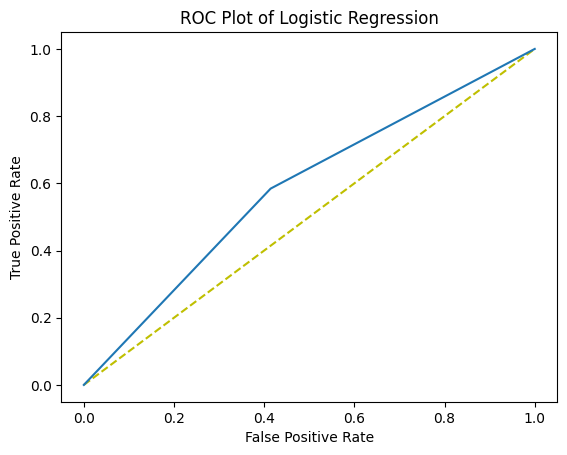

In [51]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
acc = logr.score(X_test, y_test)
print(f"Accuracy: {acc * 100: .2f} %")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot ROC Curve
y_preds = logr.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr)
plt.title('ROC Plot of Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [55]:
from sklearn.linear_model import LogisticRegression
# These are empty models to try out different ratios
logr_model_A = LogisticRegression()
logr_model_B = LogisticRegression()

# Balanced test set
test_data = pd.concat([
    df_female.sample(n=20000, random_state=42),
    df_male.sample(n=20000, random_state=42)
]).sample(frac=1) # Shuffle the test set

X_test = test_data[['SBP', 'DBP']]
y_test = test_data['Binary Sex']

Accuracy of 80/20 model: 50.03%
[[19993     7]
 [19979    21]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     20000
           1       0.75      0.00      0.00     20000

    accuracy                           0.50     40000
   macro avg       0.63      0.50      0.33     40000
weighted avg       0.63      0.50      0.33     40000



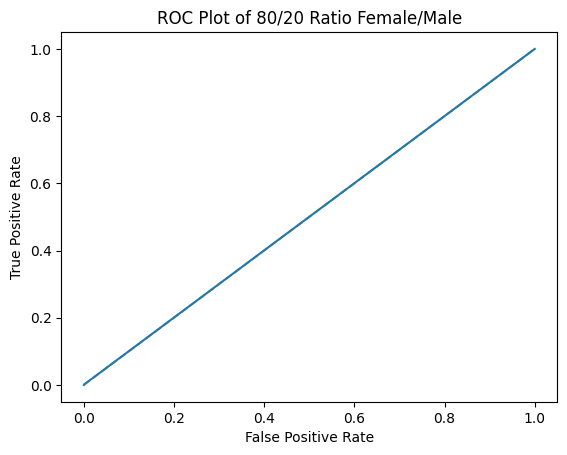

In [56]:
# Female heavy dataset (4:1)
df_80_20 = pd.concat([
    df_female.sample(n=32000, random_state=1),
    df_male.sample(n=8000, random_state=1)
]).sample(frac=1) # Shuffle the data

# Training data
X_train_8020 = df_80_20[['SBP', 'DBP']]
y_train_8020 = df_80_20['Binary Sex']

# train on new data
logr_model_A.fit(X_train_8020, y_train_8020)

# Evaluate model
y_pred_8020 = logr_model_A.predict(X_test)
acc_8020 = logr_model_A.score(X_test, y_test)

print(f"Accuracy of 80/20 model: {acc_8020 * 100:.2f}%")
print(confusion_matrix(y_test, y_pred_8020))
print(classification_report(y_test, y_pred_8020))

# Plot ROC Curve
y_preds = logr_model_A.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr)
plt.title('ROC Plot of 80/20 Ratio Female/Male')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Accuracy of Male 80/20 model: 50.02%
[[   13 19987]
 [    3 19997]]
              precision    recall  f1-score   support

           0       0.81      0.00      0.00     20000
           1       0.50      1.00      0.67     20000

    accuracy                           0.50     40000
   macro avg       0.66      0.50      0.33     40000
weighted avg       0.66      0.50      0.33     40000



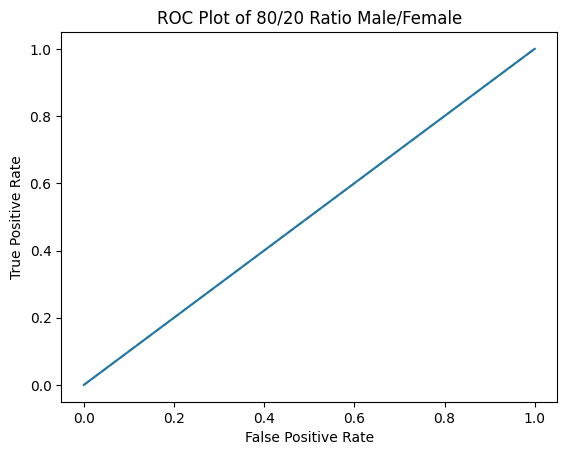

In [57]:
logr_model_C = LogisticRegression()

# Male heavy dataset (4:1)
df_20_80 = pd.concat([
    df_female.sample(n=8000, random_state=1),
    df_male.sample(n=32000, random_state=1)
]).sample(frac=1) # Shuffle the data

# Training data
X_train_2080 = df_20_80[['SBP', 'DBP']]
y_train_2080 = df_20_80['Binary Sex']

# train on new data
logr_model_C.fit(X_train_2080, y_train_2080)

# Evaluate model
y_pred_2080 = logr_model_C.predict(X_test)
acc_2080 = logr_model_C.score(X_test, y_test)

print(f"Accuracy of Male 80/20 model: {acc_2080 * 100:.2f}%")
print(confusion_matrix(y_test, y_pred_2080))
print(classification_report(y_test, y_pred_2080))

# Plot ROC Curve
y_preds = logr_model_C.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr)
plt.title('ROC Plot of 80/20 Ratio Male/Female')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Accuracy of 50/50 model: 58.21%
[[11694  8306]
 [ 8410 11590]]
              precision    recall  f1-score   support

           0       0.58      0.58      0.58     20000
           1       0.58      0.58      0.58     20000

    accuracy                           0.58     40000
   macro avg       0.58      0.58      0.58     40000
weighted avg       0.58      0.58      0.58     40000



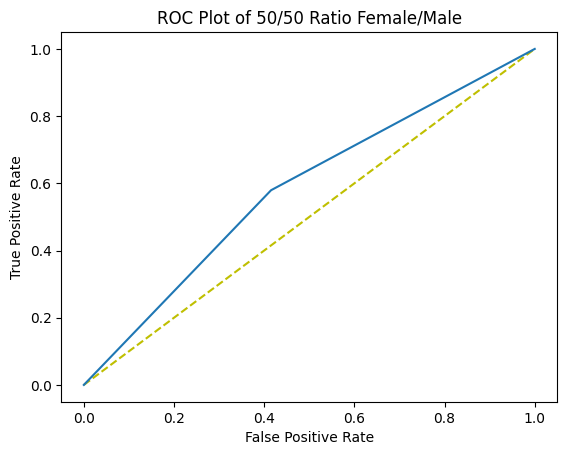

In [58]:
# Create 50/50 split training set
train_5050 = pd.concat([
    df_female.sample(n=25000, random_state=2), 
    df_male.sample(n=25000, random_state=2)   
]).sample(frac=1) # Shuffle

X_train_5050 = train_5050[['SBP', 'DBP']]
y_train_5050 = train_5050['Binary Sex']

# Fit model
logr_model_B.fit(X_train_5050, y_train_5050)

# Evaluate model
y_pred_5050 = logr_model_B.predict(X_test)
acc_5050 = logr_model_B.score(X_test, y_test)

print(f"Accuracy of 50/50 model: {acc_5050 * 100:.2f}%")
print(confusion_matrix(y_test, y_pred_5050))
print(classification_report(y_test, y_pred_5050))

# Plot ROC Curve
y_preds = logr_model_B.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr)
plt.title('ROC Plot of 50/50 Ratio Female/Male')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
from sklearn.metrics import RandomForestClassifier
rf = RandomForestClassifier(max_features=5, n_estimators=500)
rf.fit(X_train, y_train)